<a href="https://colab.research.google.com/github/rbbh/Forecasting-Time-Series-with-Algorithm-Ensembling/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [74]:
from google.colab import files
uploaded = files.upload()

Saving carsales.txt to carsales.txt


In [0]:
import io
import pandas as pd

# Un-comment the line for the data base that
# you want to predict

#data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))
data = pd.read_csv(io.BytesIO(uploaded['carsales.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['coloradoRiver.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['accidentalDeathUSA.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['electric.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['gas.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['lakeerie.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['milk.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['redwine.txt']))

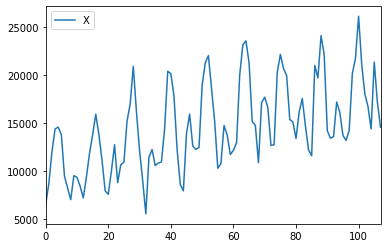

In [76]:
data.plot()


In [77]:
len(data)

108

In [0]:
#Normalizing the data
data_n = data.copy()
data_n = data/data.max()

In [79]:
# TODO: Create function for the Lag used for the prediction
# We will use 12 for the lag dimension if the series repeats 
# itself annually, 3 if it is trimestrial etc.

# Note: For the "ONS" data base, make "dimensions" = 3
# NOTE: For the "Milk" data base, make "dimensions" = 24

dimensions = 12
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

            X         X         X  ...         X         X         X
0    0.250967       NaN       NaN  ...       NaN       NaN       NaN
1    0.334419  0.250967       NaN  ...       NaN       NaN       NaN
2    0.460784  0.334419  0.250967  ...       NaN       NaN       NaN
3    0.551554  0.460784  0.334419  ...       NaN       NaN       NaN
4    0.558910  0.551554  0.460784  ...       NaN       NaN       NaN
..        ...       ...       ...  ...       ...       ...       ...
103  0.640714  0.690601  0.807847  ...  0.658531  0.521016  0.514732
104  0.551171  0.640714  0.690601  ...  0.617610  0.658531  0.521016
105  0.817732  0.551171  0.640714  ...  0.525422  0.617610  0.658531
106  0.658263  0.817732  0.551171  ...  0.506150  0.525422  0.617610
107  0.558527  0.658263  0.817732  ...  0.546036  0.506150  0.525422

[108 rows x 13 columns]


In [80]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_cn.iloc[12:,1:]

y = data_cn.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))


19
20
57


In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles's parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    threshold = 10e100
    
    best_iter = np.zeros(iterations)

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # To un-normalize the data:
          # Multiply the values by
          # data.to_numpy().max()

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point 
          # is less than prior particle's personal best point,
          # replace personal best
          if(mse < threshold):  
              threshold = mse
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = threshold
              bestRGS = rgs

              # The value below represents the current search coordinates for
              # the current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]
              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()


        for j in range(n_particles):
            rand1 = np.random.random()
            rand2 = np.random.random()

            # The variable below influences directly the particle's velocity.
            # It can either make it smaller or bigger. 
            w = inertia

            # The equation below represents Particle's velocity, which is
            # the rate of change in its position
            v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

            # Change in the Particle's position 
            c[j] = c[j] + v[j]

            # Below is a series of conditions that stop the particles from
            # leaving the search space
            if(c[j][2] < min_g):
              c[j][2] = min_g
            if(c[j][2] > max_g):
              c[j][2] = max_g
            if(c[j][1] < min_e):
              c[j][1] = min_e
            if(c[j][1] > max_e):
              c[j][1] = max_e
            if(c[j][0] < min_c):
              c[j][0] = min_c
            if(c[j][0] > max_c):
              c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))


    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')

    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = bestRGS.predict(X_test)


    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)  
      


In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [0]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [0]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

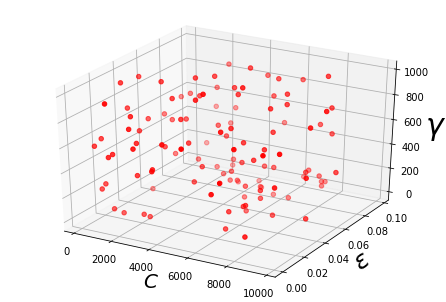





Best value iteration # 0 = 0.005526

Best value iteration # 1 = 0.005276

Best value iteration # 2 = 0.005207

Best value iteration # 3 = 0.005207

Best value iteration # 4 = 0.005206

Best value iteration # 5 = 0.005197

Best value iteration # 6 = 0.005197

Best value iteration # 7 = 0.005197

Best value iteration # 8 = 0.005197

Best value iteration # 9 = 0.005197

Best value iteration # 10 = 0.005197

Best value iteration # 11 = 0.005197

Best value iteration # 12 = 0.005197

Best value iteration # 13 = 0.005197

Best value iteration # 14 = 0.005197

Best value iteration # 15 = 0.005197

Best value iteration # 16 = 0.005197

Best value iteration # 17 = 0.005197

Best value iteration # 18 = 0.005197

Best value iteration # 19 = 0.005197

Best value iteration # 20 = 0.005197

Best value iteration # 21 = 0.005197

Best value iteration # 22 = 0.005197

Best value iteration # 23 = 0.005197

Best value iteration # 24 = 0.005197

Best value iteration # 25 = 0.005191

Best value iterati

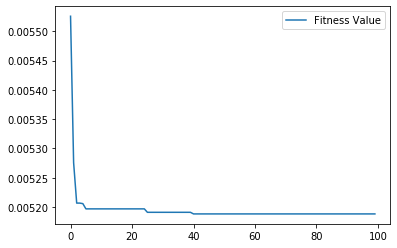

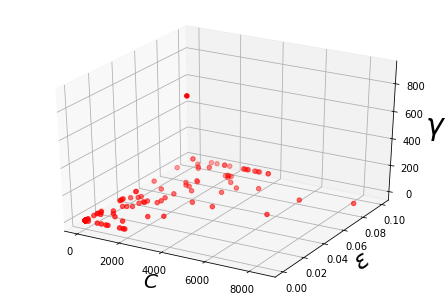





Predictions with the Population Best Value found:



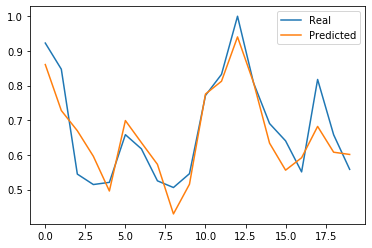





Mean Squared Error for the Test Set:	 0.004528




Predictions Average:	 0.660787




Predictions Median:	 0.634819






In [85]:
pso(120, 100, 3, 1)

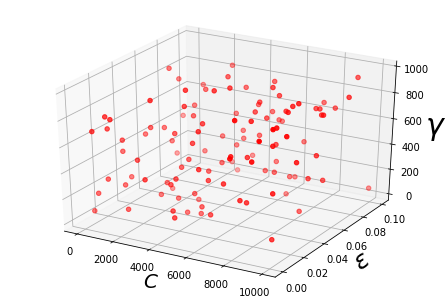





Best value iteration # 0 = 0.019101

Best value iteration # 1 = 0.005402

Best value iteration # 2 = 0.005358

Best value iteration # 3 = 0.005358

Best value iteration # 4 = 0.005224

Best value iteration # 5 = 0.005224

Best value iteration # 6 = 0.005208

Best value iteration # 7 = 0.005208

Best value iteration # 8 = 0.005208

Best value iteration # 9 = 0.005208

Best value iteration # 10 = 0.005208

Best value iteration # 11 = 0.005208

Best value iteration # 12 = 0.005208

Best value iteration # 13 = 0.005208

Best value iteration # 14 = 0.005208

Best value iteration # 15 = 0.005204

Best value iteration # 16 = 0.005193

Best value iteration # 17 = 0.005190

Best value iteration # 18 = 0.005190

Best value iteration # 19 = 0.005190

Best value iteration # 20 = 0.005190

Best value iteration # 21 = 0.005190

Best value iteration # 22 = 0.005190

Best value iteration # 23 = 0.005190

Best value iteration # 24 = 0.005190

Best value iteration # 25 = 0.005190

Best value iterati

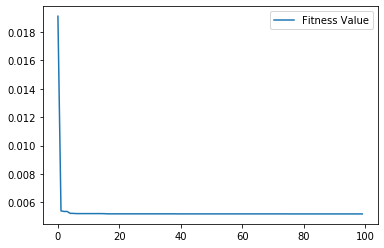

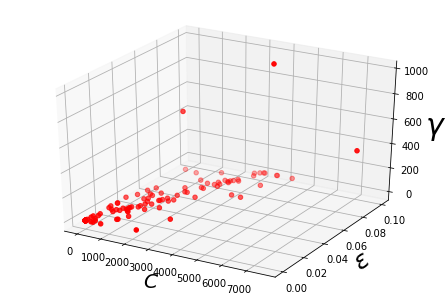





Predictions with the Population Best Value found:



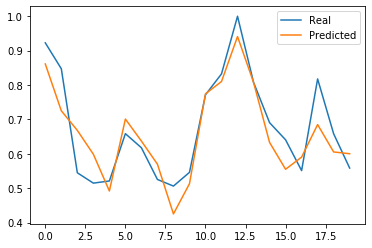





Mean Squared Error for the Test Set:	 0.004596




Predictions Average:	 0.659697




Predictions Median:	 0.635081






In [86]:
pso(120, 100, 3, 0.8)

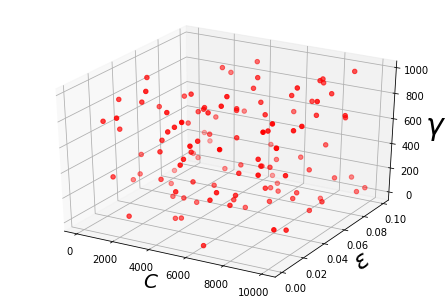





Best value iteration # 0 = 0.007468

Best value iteration # 1 = 0.006300

Best value iteration # 2 = 0.006300

Best value iteration # 3 = 0.006300

Best value iteration # 4 = 0.006300

Best value iteration # 5 = 0.006254

Best value iteration # 6 = 0.005464

Best value iteration # 7 = 0.005365

Best value iteration # 8 = 0.005365

Best value iteration # 9 = 0.005353

Best value iteration # 10 = 0.005353

Best value iteration # 11 = 0.005346

Best value iteration # 12 = 0.005346

Best value iteration # 13 = 0.005346

Best value iteration # 14 = 0.005346

Best value iteration # 15 = 0.005346

Best value iteration # 16 = 0.005346

Best value iteration # 17 = 0.005346

Best value iteration # 18 = 0.005345

Best value iteration # 19 = 0.005332

Best value iteration # 20 = 0.005332

Best value iteration # 21 = 0.005332

Best value iteration # 22 = 0.005332

Best value iteration # 23 = 0.005332

Best value iteration # 24 = 0.005332

Best value iteration # 25 = 0.005332

Best value iterati

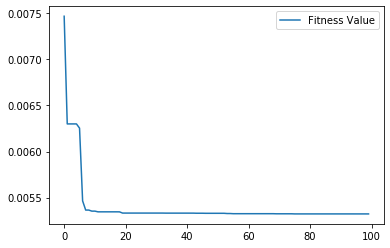

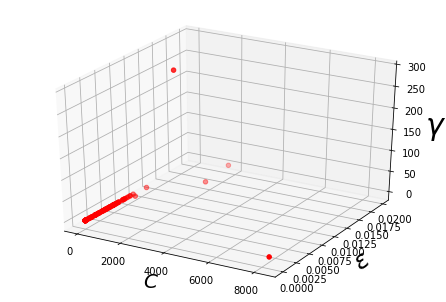





Predictions with the Population Best Value found:



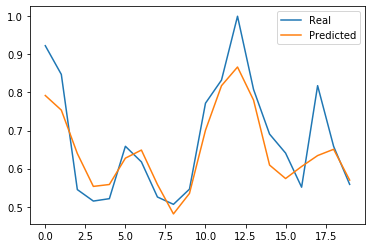





Mean Squared Error for the Test Set:	 0.005661




Predictions Average:	 0.647739




Predictions Median:	 0.630812






In [87]:
pso(120, 100, 3, 0.6)

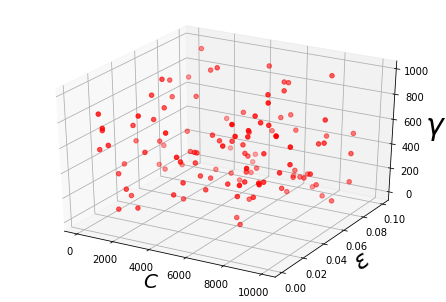





Best value iteration # 0 = 0.006536

Best value iteration # 1 = 0.005295

Best value iteration # 2 = 0.005251

Best value iteration # 3 = 0.005240

Best value iteration # 4 = 0.005219

Best value iteration # 5 = 0.005219

Best value iteration # 6 = 0.005219

Best value iteration # 7 = 0.005205

Best value iteration # 8 = 0.005205

Best value iteration # 9 = 0.005205

Best value iteration # 10 = 0.005202

Best value iteration # 11 = 0.005195

Best value iteration # 12 = 0.005188

Best value iteration # 13 = 0.005187

Best value iteration # 14 = 0.005182

Best value iteration # 15 = 0.005182

Best value iteration # 16 = 0.005182

Best value iteration # 17 = 0.005182

Best value iteration # 18 = 0.005182

Best value iteration # 19 = 0.005182

Best value iteration # 20 = 0.005179

Best value iteration # 21 = 0.005179

Best value iteration # 22 = 0.005179

Best value iteration # 23 = 0.005179

Best value iteration # 24 = 0.005179

Best value iteration # 25 = 0.005179

Best value iterati

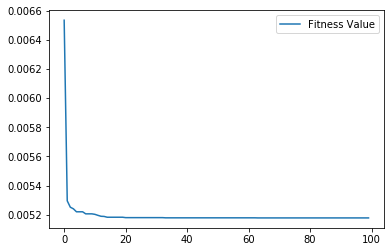

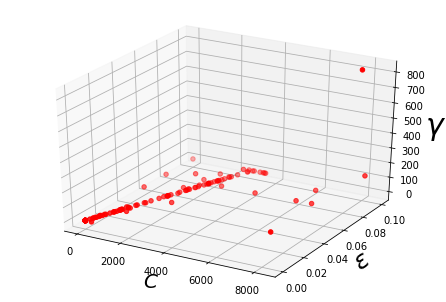





Predictions with the Population Best Value found:



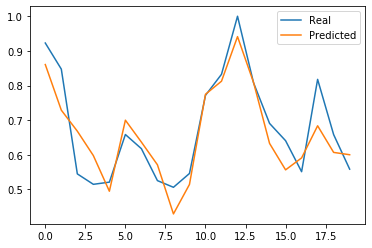





Mean Squared Error for the Test Set:	 0.004498




Predictions Average:	 0.660483




Predictions Median:	 0.634718






In [88]:
pso(120, 100, 3, 0.2)